In [1]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
df = pd.read_csv("data/df_main.csv")

## Prepare data

In [154]:
df_day = df.groupby(["day", "weekday","month", "TAVG" ]).count().reset_index()
df_day = df_day[["day", "weekday", "month", "TAVG", "Duration"]]
df_day = df_day.rename(columns={"Duration": "count"})

### Train-test-split

In [223]:
X_t, X_test, y_t, y_test = train_test_split(df_day.iloc[:,:-1], df_day.iloc[:,-1], test_size=0.33, random_state=42)

In [224]:
#check:
X_t.shape, X_test.shape, y_t.shape, y_test.shape

((244, 4), (121, 4), (244,), (121,))

### Feature Engineering

In [225]:
def feature_engineering(data):
    
    #data_w = encode_weekends(data)
    data_h = encode_holidays(data)
    data_d = dummies_weekdays(data_h)
    data_p = polynomial_interaction(data_d)
    data_n = scaling_s(data_p)   
    data_n = data_n.drop(["x0", "x1"], axis=1)
    
    return data_n

In [226]:
def encode_weekends(X_train):
    X_train.loc[(X_train["weekday"] == "Saturday") | (X_train["weekday"] == "Sunday"), "weekend"] = 1
    X_train["weekend"] = X_train["weekend"].fillna(0)
    return X_train

In [227]:
def encode_holidays(X_train):
    cal = calendar()
    holidays = list(cal.holidays(start=df_day["day"].min(), end=df_day["day"].max()))
    holidays = [str(x.date()) for x in holidays]
    X_train.loc[(df_day["day"].isin(holidays)), "holiday"] = 1
    X_train["holiday"] = X_train["holiday"].fillna(0)
    X_train.set_index("day", inplace=True)
    return X_train    

In [228]:
def dummies_weekdays(X_train):
    dummies = pd.get_dummies(X_train['weekday'])
    X_train = pd.concat([X_train, dummies.set_index(X_train.index)], axis=1) 
    X_train.drop(["Monday", "weekday"], axis=1, inplace=True)
    return X_train

In [229]:
def polynomial_interaction(X_train):
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(X_train[["month", "TAVG"]])
    c_names = poly.get_feature_names()
    df_poly = pd.DataFrame(x_poly, columns= c_names)
    X_train = X_train.reset_index()
    X_train = pd.concat([X_train, df_poly], axis=1)
    return X_train

In [230]:
def scaling_s(X_train):
    Scale = StandardScaler()
    scaled = Scale.fit_transform(X_train[["month", "TAVG", "x0", "x1", "x0^2", "x0 x1", "x1^2"]])
    scaled = pd.DataFrame(scaled, columns=["month", "TAVG", "x0", "x1", "x0^2", "x0 x1", "x1^2"])
    X_train = X_train.drop(["month", "TAVG", "x0", "x1", "x0^2", "x0 x1", "x1^2"], axis=1)
    X_train = pd.concat([X_train, scaled], axis=1)
    X_train = X_train.set_index("day")
    return X_train

In [231]:
def scaling_y(y):
    y = pd.DataFrame(y)
    Scale = StandardScaler()
    scaled = Scale.fit_transform(y)
    return scaled

In [232]:
X = feature_engineering(X_t)

In [33]:
#X.set_index("day", inplace=True)

KeyError: "None of ['day'] are in the columns"

In [233]:
X

,holiday,Friday,Saturday,Sunday,Thursday,Tuesday,Wednesday,1,month,TAVG,x0^2,x0 x1,x1^2
day,,,,,,,,,,,,,
2019-04-29,0.0,0,0,0,0,0,0,1.0,-0.771261,-0.447607,-0.858827,-0.832586,-0.749662
2019-02-01,0.0,1,0,0,0,0,0,1.0,-1.372500,-2.359344,-1.128813,-1.595902,-1.009508
2019-02-06,0.0,0,0,0,0,0,1,1.0,-1.372500,-0.534172,-1.128813,-1.142165,-0.814360
2019-10-13,0.0,0,0,1,0,0,0,1.0,1.032455,-0.041898,1.031072,0.535886,-0.379528
2019-07-01,0.0,0,0,0,0,0,0,1.0,0.130597,1.059463,-0.116367,0.910802,1.181336
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-13,0.0,0,0,0,0,0,1,1.0,-1.071881,-0.969085,-1.016319,-1.171074,-1.063429
2019-04-17,0.0,0,0,0,0,0,1,1.0,-0.771261,0.160436,-0.858827,-0.530267,-0.153720
2019-09-28,0.0,0,1,0,0,0,0,1.0,0.731836,0.798724,0.603595,1.281830,0.738383


## Models

Which model? 
- Linear Regression: check Assumptions
- Random Forest
- KNN Regressor

In [234]:
y = scaling_y(y_t)

### Linear Regression

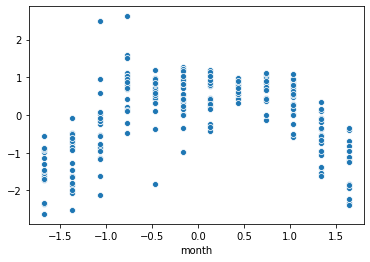

In [255]:
# check assumptions for linear model: 
sns.scatterplot(X["month"], y[:,0])

In [ ]:
# features that have a linear relationship: TAVG, dummies, x0 x1, 
# but with all of them: 10% better
# still not very good because 

In [250]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [237]:
linreg = LinearRegression()

In [238]:
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [239]:
linreg.score(X, y)   # all features: 0.7304412054095764

0.7304412054095764

In [249]:
ypred = linreg.predict(X)
ypred

array([[ 0.15843935],
       [-2.13379137],
       [-0.28988868],
       [-0.15721791],
       [ 0.67216681],
       [-0.32513428],
       [-0.02866498],
       [ 0.69596484],
       [ 0.83739264],
       [ 0.30276338],
       [-0.64439959],
       [ 0.36078195],
       [ 0.14447818],
       [-1.39090645],
       [-1.31649368],
       [ 0.58733076],
       [-1.60068941],
       [ 0.88401979],
       [ 0.00905985],
       [-0.28521578],
       [ 0.1869475 ],
       [ 0.22393005],
       [ 0.88987142],
       [ 0.7792027 ],
       [ 0.6567493 ],
       [ 0.58137751],
       [ 0.69093617],
       [ 0.27874639],
       [-0.04306244],
       [ 0.77977659],
       [-0.04160132],
       [ 0.74765668],
       [-0.05270523],
       [ 0.39333861],
       [ 0.42236107],
       [-0.76528415],
       [-0.80895046],
       [-0.38278012],
       [ 0.73167719],
       [ 0.78403435],
       [-0.59333251],
       [ 0.820151  ],
       [ 0.48237093],
       [ 0.18418761],
       [-1.18981583],
       [ 0

In [251]:
mean_squared_error(y, ypred)

0.26955879459042364

###  TEST

In [240]:
x_test = feature_engineering(X_test)

In [241]:
y_test = scaling_y(y_test)

In [248]:
# test-accuracy
linreg.score(x_test, y_test)

0.6374280164400226

In [253]:
yt_pred = linreg.predict(x_test)

In [254]:
mean_squared_error(y_test, yt_pred)

0.3625719835599775

## KNN-Regressor

## Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [101]:
rf = RandomForestRegressor(max_depth=5)

In [134]:
rf.fit(X, y_train)  
# training accuracy:
rf.score(X, y_train.values.ravel())

0.8538172983162207

In [135]:
#test accuracy
rf.score(x_test, y_test)

0.6077591994535917

In [ ]:
## Regularization

In [ ]:
## Hyperparameter Optimization

In [ ]:
#split train/test set
from sklearn.model_selection import train_test_split

In [ ]:
Xtrain_forest, Xtest_forest, ytrain_forest, ytest_forest = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)
Xtrain_forest.shape, ytrain_forest.shape

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [6, 8, 16],
    'n_estimators': [10, 100, 200]
}
param_grid

In [ ]:
cv = GridSearchCV(rf, param_grid, 
                  return_train_score=True,
                  cv=2, n_jobs=4)

forest=cv.fit(Xtrain_forest, ytrain_forest)

ypred_forest=forest.predict(Xtest_forest)
forest.score(Xtest_forest,ytest_forest)

In [ ]:
cv.best_estimator_

In [ ]:
# After getting good models: retrain them on ALL data! 